In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
#  ĐỌC DỮ LIỆU GỐC
df = pd.read_csv("Guland.vn.csv", dtype=str)
print(f"Kích thước dữ liệu gốc: {df.shape}")
print(f"Các cột: {df.columns.tolist()}")

# Hiển thị dữ liệu gốc để kiểm tra
print("\n--- 10 dòng đầu tiên ---")
print(df[["Price", "Area", "Property Type", "Location"]].head(10))

Kích thước dữ liệu gốc: (236226, 28)
Các cột: ['Title', 'Price', 'Area', 'Location', 'Listing ID', 'Last Updated', 'Property Type', 'Width', 'Length', 'Bedrooms', 'Bathrooms', 'Floors', 'Position', 'Direction', 'Alley Width', 'Road Type', 'Description', 'Latitude', 'Longitude', 'VIP Account', 'Avatar', 'Agent Role', 'Agent Name', 'Agent Listing Count', 'Province', 'Property Type Slug', 'Scraped At', 'Last Updated Date']

--- 10 dòng đầu tiên ---
     Price    Area Property Type  \
0   2700.0    78.7     Nhà riêng   
1   2000.0   192.0     Nhà riêng   
2    600.0    34.2     Nhà riêng   
3   5000.0  1232.8     Nhà riêng   
4   6000.0   298.0     Nhà riêng   
5  13000.0  4700.0     Nhà riêng   
6  10000.0   117.4     Nhà riêng   
7   4500.0   108.3     Nhà riêng   
8   3200.0   390.0     Nhà riêng   
9   2200.0    31.3     Nhà riêng   

                                        Location  
0                       Xã An Biên,An Giang(Mới)  
1                Phường Long Xuyên,An Giang(Mới)  


In [3]:
#  LÀM SẠCH DỮ LIỆU CƠ BẢN

# Hàm làm sạch giá
def clean_price(price_str):
    if pd.isna(price_str):
        return None
    price_str = str(price_str).lower().replace(",", ".").strip()
    
    # Loại bỏ giá thỏa thuận
    if "giá thỏa thuận" in price_str or "thương lượng" in price_str or "liên hệ" in price_str:
        return None
    
    # Giá theo đơn vị
    if "tỷ" in price_str:
        nums = re.findall(r"[\d\.]+", price_str)
        if nums:
            return float(nums[0]) * 1000000000  # 1 tỷ = 1 tỷ VND
    elif "triệu" in price_str:
        nums = re.findall(r"[\d\.]+", price_str)
        if nums:
            return float(nums[0]) * 1000000  # 1 triệu = 1,000,000 VND
    elif "ngàn" in price_str or "nghìn" in price_str:
        nums = re.findall(r"[\d\.]+", price_str)
        if nums:
            return float(nums[0]) * 1000  # 1 ngàn = 1,000 VND
    
    # Fallback: tìm số trực tiếp
    nums = re.findall(r"[\d\.]+", price_str)
    if nums:
        num = float(nums[0])
        # Nếu số quá nhỏ (< 100) có thể là tỷ, nếu lớn (> 1000) có thể là triệu
        if num < 100:
            return num * 1000000000  # tỷ
        else:
            return num * 1000000  # triệu
    
    return None

# Hàm làm sạch diện tích
def clean_area(area_str):
    if pd.isna(area_str):
        return None
    area_str = str(area_str).lower().replace(",", ".")
    
    # Tìm số (có thể có dấu chấm thập phân)
    nums = re.findall(r"[\d\.]+", area_str)
    if nums:
        area = float(nums[0])
        # Nếu diện tích quá lớn (> 1000) có thể là nhầm đơn vị
        if area > 1000:
            return area / 100  # chia để điều chỉnh
        return area
    return None

# %%
# Áp dụng làm sạch
df["Price_clean"] = df["Price"].apply(clean_price)
df["Area_clean"] = df["Area"].apply(clean_area)

# Loại bỏ dòng có giá trị null
initial_count = len(df)
df = df.dropna(subset=["Price_clean", "Area_clean"])
after_clean_count = len(df)

print(f"Đã loại bỏ {initial_count - after_clean_count} dòng có giá/diện tích không hợp lệ")
print(f"Số dòng còn lại: {after_clean_count}")

Đã loại bỏ 296 dòng có giá/diện tích không hợp lệ
Số dòng còn lại: 235930


In [4]:
# Tính giá/m2
df["Price_per_m2"] = df["Price_clean"] / df["Area_clean"]

# Kiểm tra kết quả làm sạch
print("\n--- KẾT QUẢ LÀM SẠCH ---")
sample_data = df[["Price", "Price_clean", "Area", "Area_clean", "Price_per_m2"]].head(10).copy()
sample_data["Price_clean_formatted"] = sample_data["Price_clean"].apply(lambda x: f"{x:,.0f}" if pd.notna(x) else "NaN")
sample_data["Price_per_m2_formatted"] = sample_data["Price_per_m2"].apply(lambda x: f"{x:,.0f}" if pd.notna(x) else "NaN")
print(sample_data[["Price", "Price_clean_formatted", "Area", "Area_clean", "Price_per_m2_formatted"]])


--- KẾT QUẢ LÀM SẠCH ---
     Price Price_clean_formatted    Area  Area_clean Price_per_m2_formatted
0   2700.0         2,700,000,000    78.7      78.700             34,307,497
1   2000.0         2,000,000,000   192.0     192.000             10,416,667
2    600.0           600,000,000    34.2      34.200             17,543,860
3   5000.0         5,000,000,000  1232.8      12.328            405,580,792
4   6000.0         6,000,000,000   298.0     298.000             20,134,228
5  13000.0        13,000,000,000  4700.0      47.000            276,595,745
6  10000.0        10,000,000,000   117.4     117.400             85,178,876
7   4500.0         4,500,000,000   108.3     108.300             41,551,247
8   3200.0         3,200,000,000   390.0     390.000              8,205,128
9   2200.0         2,200,000,000    31.3      31.300             70,287,540


In [5]:
#  XỬ LÝ OUTLIERS

def remove_outliers_multiple(df, columns):
    """
    Xử lý outliers cho nhiều cột cùng lúc
    """
    if len(df) == 0:
        return df
        
    mask = pd.Series([True] * len(df))
    
    for col in columns:
        if col not in df.columns:
            print(f" Cảnh báo: Cột '{col}' không tồn tại")
            continue
            
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        # Đảm bảo lower không âm cho các giá trị không thể âm
        if col in ['Price_clean', 'Area_clean', 'Price_per_m2']:
            lower = max(lower, 0)
        
        col_mask = (df[col] >= lower) & (df[col] <= upper)
        mask = mask & col_mask
        
        removed_count = len(df) - col_mask.sum()
        print(f"{col}: Giữ lại {col_mask.sum():,} / {len(df):,} dòng (Loại bỏ {removed_count:,} outliers)")
    
    result_df = df[mask].copy()
    print(f"\nTổng số dòng sau xử lý outliers: {len(result_df):,}")
    return result_df

# Áp dụng xử lý outliers
df_clean = remove_outliers_multiple(df, ['Price_clean', 'Area_clean', 'Price_per_m2'])

Price_clean: Giữ lại 201,594 / 235,930 dòng (Loại bỏ 34,336 outliers)
Area_clean: Giữ lại 210,348 / 235,930 dòng (Loại bỏ 25,582 outliers)
Price_per_m2: Giữ lại 203,245 / 235,930 dòng (Loại bỏ 32,685 outliers)

Tổng số dòng sau xử lý outliers: 172,690


In [6]:
#  XỬ LÝ CÁC BIẾN PHÂN LOẠI

# Tách địa chỉ nếu có cột Location
if 'Location' in df_clean.columns:
    location_split = df_clean['Location'].str.split(',', n=2, expand=True)
    if location_split.shape[1] >= 3:
        df_clean['Street'] = location_split[0].str.strip()
        df_clean['District'] = location_split[1].str.strip()
        df_clean['Province'] = location_split[2].str.strip()
        print("Đã tách cột Location thành Street, District, Province")
    else:
        print(" Cột Location không có đủ thông tin để tách")

# Thống kê biến phân loại
categorical_cols = ['Property Type', 'Legal Status']
for col in categorical_cols:
    if col in df_clean.columns:
        print(f"\n--- Phân phối {col} ---")
        print(df_clean[col].value_counts().head(10))

Đã tách cột Location thành Street, District, Province

--- Phân phối Property Type ---
Property Type
Đất                91455
Nhà riêng          57519
Căn hộ chung cư    19942
Kho, nhà xưởng      1681
Nhà trọ             1536
Khách sạn            403
Văn phòng            154
Name: count, dtype: int64


In [7]:
#  TRÍCH XUẤT TỪ KHÓA TỪ TIÊU ĐỀ

if 'Title' in df_clean.columns:
    # Làm sạch title
    df_clean['Title'] = df_clean['Title'].fillna('')
    df_clean['Title_Length'] = df_clean['Title'].str.len()
    
    # Trích xuất từ khóa quan trọng
    important_keywords = ['chính chủ', 'giá rẻ', 'view đẹp', 'mặt tiền', 'sổ đỏ', 'sổ hồng']
    for keyword in important_keywords:
        df_clean[f'Keyword_{keyword.replace(" ", "_")}'] = df_clean['Title'].str.contains(keyword, case=False, na=False).astype(int)
    
    print("Đã trích xuất các từ khóa quan trọng từ tiêu đề")

Đã trích xuất các từ khóa quan trọng từ tiêu đề


In [8]:
#  THỐNG KÊ MÔ TẢ HOÀN CHỈNH

def format_currency(x):
    """Định dạng tiền tệ dễ đọc"""
    if pd.isna(x):
        return "NaN"
    if x >= 1e9:  # Tỷ đồng
        return f"{x/1e9:,.1f} tỷ"
    elif x >= 1e6:  # Triệu đồng
        return f"{x/1e6:,.0f} triệu"
    elif x >= 1e3:  # Ngàn đồng
        return f"{x/1e3:,.0f} nghìn"
    else:
        return f"{x:,.0f} VND"

def format_area(x):
    """Định dạng diện tích"""
    if pd.isna(x):
        return "NaN"
    return f"{x:,.0f} m²"

# Thống kê cho biến định lượng
numeric_cols = ['Price_clean', 'Area_clean', 'Price_per_m2']
print("Thống kê biến định lượng")

for col in numeric_cols:
    if col in df_clean.columns:
        print(f"\n--- {col} ---")
        stats = df_clean[col].describe()
        
        if col == 'Price_clean':
            formatter = format_currency
        elif col == 'Area_clean':
            formatter = format_area
        else:  # Price_per_m2
            formatter = lambda x: f"{format_currency(x)}/m²" if pd.notna(x) else "NaN"
        
        print(f"Số lượng:    {int(stats['count']):,}")
        print(f"Trung bình:  {formatter(stats['mean'])}")
        print(f"Độ lệch chuẩn: {formatter(stats['std'])}")
        print(f"Tối thiểu:   {formatter(stats['min'])}")
        print(f"25%:         {formatter(stats['25%'])}")
        print(f"Trung vị:    {formatter(stats['50%'])}")
        print(f"75%:         {formatter(stats['75%'])}")
        print(f"Tối đa:      {formatter(stats['max'])}")

# Thống kê cho biến phân loại
print("\nThống kê biến phân loại")

categorical_stats = ['Property Type', 'Legal Status', 'District', 'Province']
for col in categorical_stats:
    if col in df_clean.columns:
        print(f"\n--- Phân phối {col} ---")
        value_counts = df_clean[col].value_counts()
        for i, (value, count) in enumerate(value_counts.head(10).items()):
            percentage = (count / len(df_clean)) * 100
            print(f"{i+1:2d}. {value:<30} {count:>5,} dòng ({percentage:.1f}%)")

Thống kê biến định lượng

--- Price_clean ---
Số lượng:    172,690
Trung bình:  7.3 tỷ
Độ lệch chuẩn: 7.9 tỷ
Tối thiểu:   0 VND
25%:         1.9 tỷ
Trung vị:    4.4 tỷ
75%:         9.4 tỷ
Tối đa:      41.5 tỷ

--- Area_clean ---
Số lượng:    172,690
Trung bình:  108 m²
Độ lệch chuẩn: 70 m²
Tối thiểu:   1 m²
25%:         60 m²
Trung vị:    90 m²
75%:         136 m²
Tối đa:      346 m²

--- Price_per_m2 ---
Số lượng:    172,690
Trung bình:  92 triệu/m²
Độ lệch chuẩn: 101 triệu/m²
Tối thiểu:   0 VND/m²
25%:         20 triệu/m²
Trung vị:    56 triệu/m²
75%:         125 triệu/m²
Tối đa:      509 triệu/m²

Thống kê biến phân loại

--- Phân phối Property Type ---
 1. Đất                            91,455 dòng (53.0%)
 2. Nhà riêng                      57,519 dòng (33.3%)
 3. Căn hộ chung cư                19,942 dòng (11.5%)
 4. Kho, nhà xưởng                 1,681 dòng (1.0%)
 5. Nhà trọ                        1,536 dòng (0.9%)
 6. Khách sạn                        403 dòng (0.2%)
 7. Văn phò

In [9]:
#  PHÂN TÍCH MỐI QUAN HỆ CƠ BẢN

# Mối quan hệ giữa diện tích và giá
if all(col in df_clean.columns for col in ['Area_clean', 'Price_clean']):
    correlation = df_clean['Area_clean'].corr(df_clean['Price_clean'])
    print(f" Tương quan giữa Diện tích và Giá: {correlation:.3f}")
    
    if abs(correlation) > 0.5:
        print("   → Mối quan hệ mạnh")
    elif abs(correlation) > 0.3:
        print("   → Mối quan hệ trung bình")
    else:
        print("   → Mối quan hệ yếu")

# Giá trung bình theo loại hình BĐS
if 'Property Type' in df_clean.columns:
    print(f"\n Giá trung bình theo loại hình bất động sản")
    price_by_type = df_clean.groupby('Property Type')['Price_clean'].agg(['count', 'mean', 'median']).round(0)
    price_by_type = price_by_type.sort_values('count', ascending=False)
    
    for prop_type, row in price_by_type.head().iterrows():
        mean_price = format_currency(row['mean'])
        median_price = format_currency(row['median'])
        print(f"   {prop_type:<20}: {row['count']:>3} BĐS | TB: {mean_price:>15} | Trung vị: {median_price:>15}")

 Tương quan giữa Diện tích và Giá: 0.086
   → Mối quan hệ yếu

 Giá trung bình theo loại hình bất động sản
   Đất                 : 91455.0 BĐS | TB:          5.1 tỷ | Trung vị:          2.6 tỷ
   Nhà riêng           : 57519.0 BĐS | TB:         10.7 tỷ | Trung vị:          7.9 tỷ
   Căn hộ chung cư     : 19942.0 BĐS | TB:          6.6 tỷ | Trung vị:          4.3 tỷ
   Kho, nhà xưởng      : 1681.0 BĐS | TB:         13.0 tỷ | Trung vị:         10.0 tỷ
   Nhà trọ             : 1536.0 BĐS | TB:          7.4 tỷ | Trung vị:          5.3 tỷ


In [10]:
#  XUẤT KẾT QUẢ

# Lưu file đã làm sạch
output_file = "Guland_cleaned.csv"
df_clean.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"Đã lưu file đã làm sạch: {output_file}")

# Tóm tắt kết quả
print(f"\nTóm tắt kết quả")
print(f"• Số lượng BĐS ban đầu: {len(df):,}")
print(f"• Số lượng BĐS sau làm sạch: {len(df_clean):,}")
print(f"• Tỷ lệ giữ lại: {len(df_clean)/len(df)*100:.1f}%")

if len(df_clean) > 0:
    avg_price = format_currency(df_clean['Price_clean'].mean())
    avg_area = format_area(df_clean['Area_clean'].mean())
    avg_price_m2 = format_currency(df_clean['Price_per_m2'].mean()) + "/m²"
    
    print(f"• Giá trung bình: {avg_price}")
    print(f"• Diện tích trung bình: {avg_area}")
    print(f"• Giá/m² trung bình: {avg_price_m2}")

print(f"\nHoàn tất xử lý dữ liệu")

# Hiển thị một số dòng kết quả cuối cùng
print("\n=== Dữ liệu sau khi xử lý ===")
final_cols = [col for col in ['Price_clean', 'Area_clean', 'Price_per_m2', 'Property Type', 'District', 'Province'] if col in df_clean.columns]
print(df_clean[final_cols].head(10))

Đã lưu file đã làm sạch: Guland_cleaned.csv

Tóm tắt kết quả
• Số lượng BĐS ban đầu: 235,930
• Số lượng BĐS sau làm sạch: 172,690
• Tỷ lệ giữ lại: 73.2%
• Giá trung bình: 7.3 tỷ
• Diện tích trung bình: 108 m²
• Giá/m² trung bình: 92 triệu/m²

Hoàn tất xử lý dữ liệu

=== Dữ liệu sau khi xử lý ===
     Price_clean  Area_clean  Price_per_m2 Property Type          District  \
0   2.700000e+09      78.700  3.430750e+07     Nhà riêng     An Giang(Mới)   
1   2.000000e+09     192.000  1.041667e+07     Nhà riêng     An Giang(Mới)   
2   6.000000e+08      34.200  1.754386e+07     Nhà riêng     An Giang(Mới)   
3   5.000000e+09      12.328  4.055808e+08     Nhà riêng     An Giang(Mới)   
4   6.000000e+09     298.000  2.013423e+07     Nhà riêng  Đặc khu Phú Quốc   
5   1.300000e+10      47.000  2.765957e+08     Nhà riêng     An Giang(Mới)   
6   1.000000e+10     117.400  8.517888e+07     Nhà riêng     An Giang(Mới)   
7   4.500000e+09     108.300  4.155125e+07     Nhà riêng     An Giang(Mới)   
9

In [11]:
# Set style cho đồ thị
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [12]:
# Load dữ liệu đã làm sạch
try:
    df = pd.read_csv("Guland_cleaned.csv")
    print(f" Kích thước dữ liệu EDA: {df.shape}")
except:
    print(" Không tìm thấy file Guland_cleaned.csv")
    print(" Hãy chạy lại code xử lý dữ liệu trước khi chạy EDA")
    df = pd.DataFrame()

if len(df) == 0:
    print(" Không có dữ liệu để phân tích")
else:
    print(" Dữ liệu đã được load thành công")

 Kích thước dữ liệu EDA: (172690, 40)
 Dữ liệu đã được load thành công


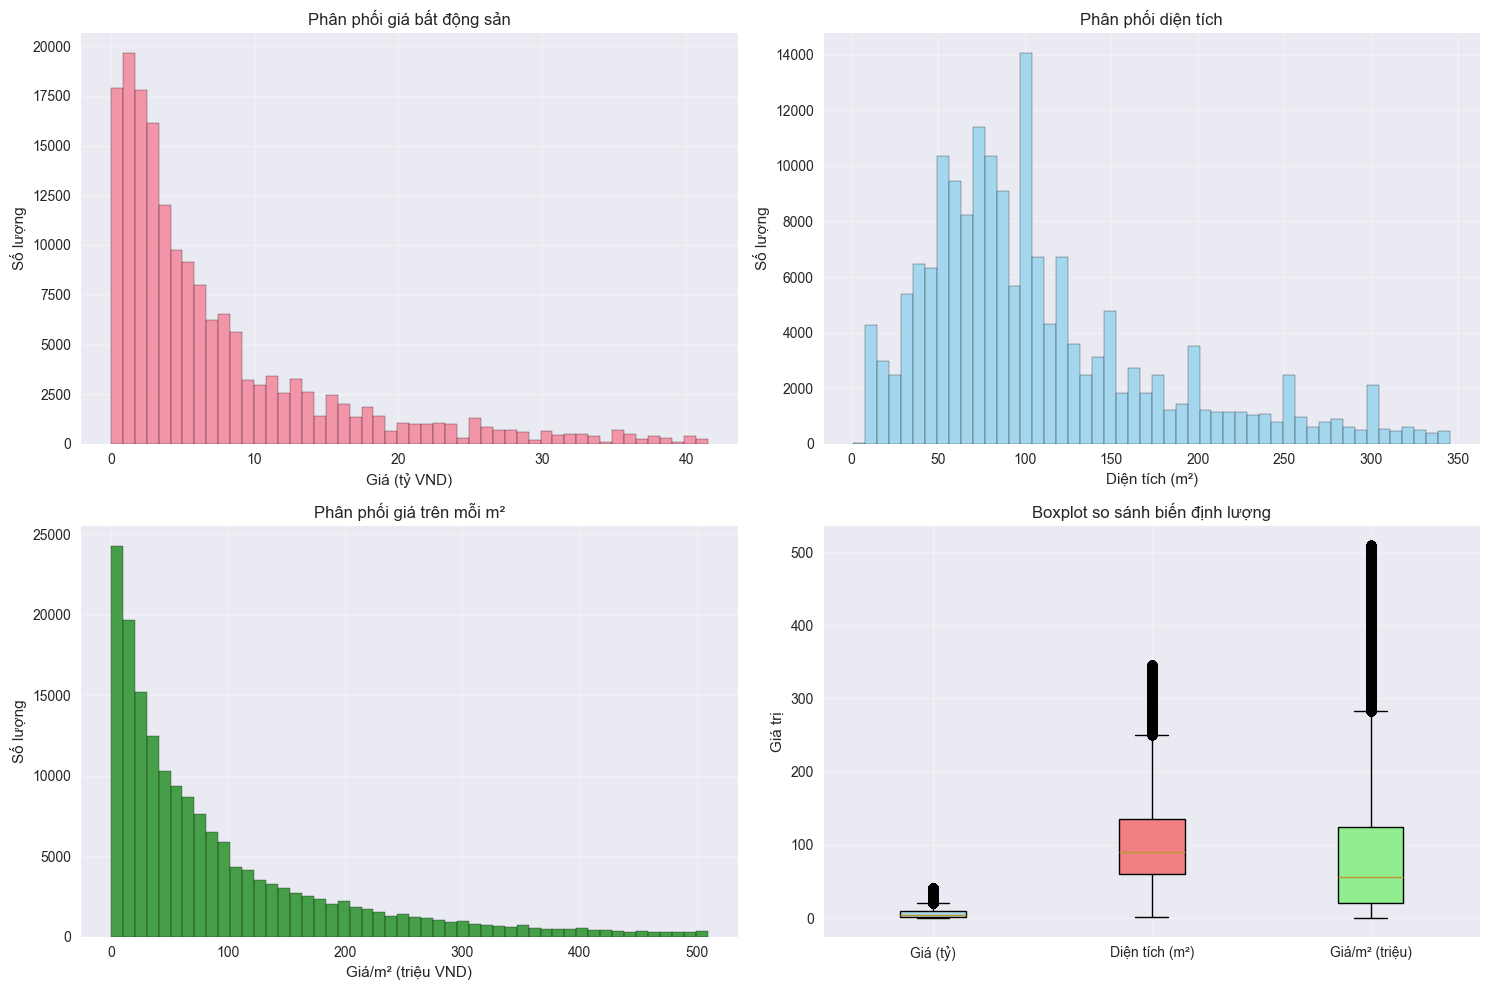

In [13]:
##  PHÂN TÍCH PHÂN PHỐI CÁC BIẾN CHÍNH

# %%
if len(df) > 0:
    # 1.1 Phân phối giá bất động sản
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Phân phối giá (chuyển đổi đơn vị trước khi vẽ)
    price_billion = df['Price_clean'] / 1e9
    axes[0,0].hist(price_billion, bins=50, alpha=0.7, edgecolor='black')
    axes[0,0].set_xlabel('Giá (tỷ VND)')
    axes[0,0].set_ylabel('Số lượng')
    axes[0,0].set_title('Phân phối giá bất động sản')
    axes[0,0].grid(True, alpha=0.3)

    # Phân phối diện tích
    axes[0,1].hist(df['Area_clean'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
    axes[0,1].set_xlabel('Diện tích (m²)')
    axes[0,1].set_ylabel('Số lượng')
    axes[0,1].set_title('Phân phối diện tích')
    axes[0,1].grid(True, alpha=0.3)

    # Phân phối giá/m² (chuyển đổi đơn vị)
    price_m2_million = df['Price_per_m2'] / 1e6
    axes[1,0].hist(price_m2_million, bins=50, alpha=0.7, edgecolor='black', color='green')
    axes[1,0].set_xlabel('Giá/m² (triệu VND)')
    axes[1,0].set_ylabel('Số lượng')
    axes[1,0].set_title('Phân phối giá trên mỗi m²')
    axes[1,0].grid(True, alpha=0.3)

    # Boxplot so sánh (dữ liệu đã chuyển đổi)
    plot_data = [price_billion, df['Area_clean'], price_m2_million]
    labels = ['Giá (tỷ)', 'Diện tích (m²)', 'Giá/m² (triệu)']
    box_plot = axes[1,1].boxplot(plot_data, labels=labels, patch_artist=True)
    
    # Tô màu cho boxplot
    colors = ['lightblue', 'lightcoral', 'lightgreen']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[1,1].set_ylabel('Giá trị')
    axes[1,1].set_title('Boxplot so sánh biến định lượng')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [14]:
# %%
if len(df) > 0:
    # 1.2 Thống kê mô tả chi tiết
    print(" THỐNG KÊ MÔ TẢ CHI TIẾT")

    def detailed_stats(series, name):
        print(f"\n--- {name} ---")
        print(f"Mean: {series.mean():,.0f}")
        print(f"Median: {series.median():,.0f}")
        print(f"Std: {series.std():,.0f}")
        print(f"Min: {series.min():,.0f}")
        print(f"Max: {series.max():,.0f}")
        print(f"Skewness: {series.skew():.3f} ({'Lệch phải' if series.skew() > 0 else 'Lệch trái' if series.skew() < 0 else 'Đối xứng'})")
        print(f"Kurtosis: {series.kurtosis():.3f}")

    detailed_stats(df['Price_clean'], "Giá bất động sản (VND)")
    detailed_stats(df['Area_clean'], "Diện tích (m²)")
    detailed_stats(df['Price_per_m2'], "Giá trên m² (VND/m²)")

 THỐNG KÊ MÔ TẢ CHI TIẾT

--- Giá bất động sản (VND) ---
Mean: 7,268,411,797
Median: 4,390,000,000
Std: 7,934,074,770
Min: 0
Max: 41,500,000,000
Skewness: 1.886 (Lệch phải)
Kurtosis: 3.472

--- Diện tích (m²) ---
Mean: 108
Median: 90
Std: 70
Min: 1
Max: 346
Skewness: 1.228 (Lệch phải)
Kurtosis: 1.110

--- Giá trên m² (VND/m²) ---
Mean: 91,854,439
Median: 55,847,610
Std: 100,896,640
Min: 0
Max: 509,433,962
Skewness: 1.731 (Lệch phải)
Kurtosis: 2.810


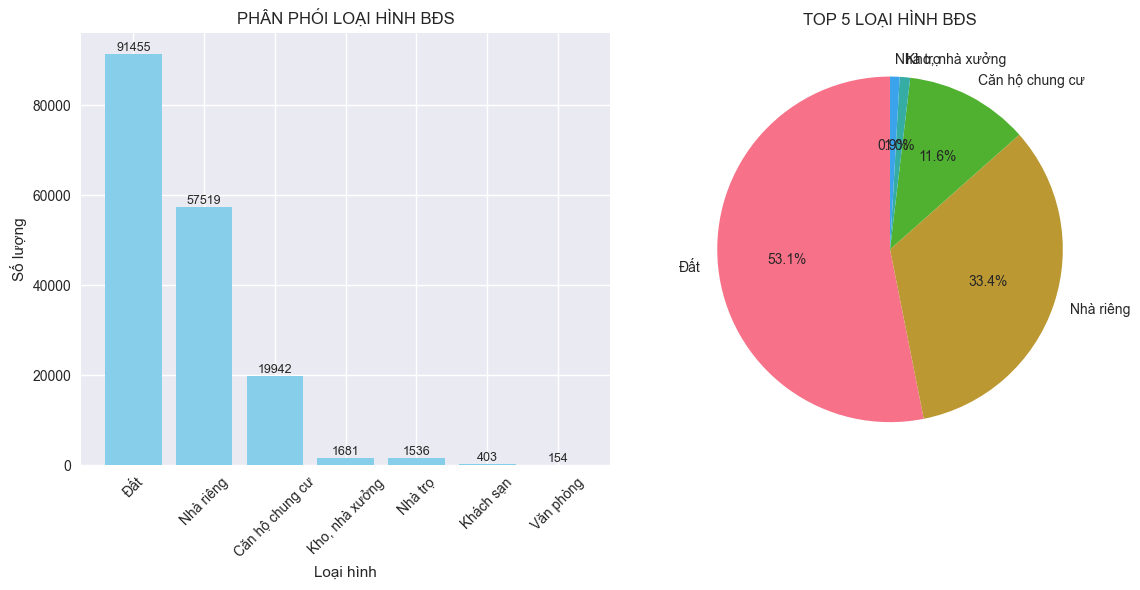

 GIÁ TRUNG BÌNH THEO LOẠI HÌNH BĐS
                 Count    Price_Mean  Price_Median  Area_Mean  Price_m2_Mean
Property Type                                                               
Đất              91455  5.122771e+09  2.580000e+09      126.0     61517859.0
Nhà riêng        57519  1.066921e+10  7.900000e+09       91.0    140872409.0
Căn hộ chung cư  19942  6.623218e+09  4.300000e+09       79.0     84373057.0
Kho, nhà xưởng    1681  1.296941e+10  1.000000e+10      134.0    136928596.0
Nhà trọ           1536  7.405097e+09  5.325000e+09       91.0     93594235.0
Khách sạn          403  1.520436e+10  1.490000e+10      121.0    140272557.0
Văn phòng          154  1.047770e+10  4.350000e+09       93.0    132157018.0


In [15]:
##  PHÂN TÍCH THEO LOẠI HÌNH BẤT ĐỘNG SẢN

# %%
if len(df) > 0 and 'Property Type' in df.columns:
    # 2.1 Phân phối loại hình BĐS
    plt.figure(figsize=(12, 6))
    prop_type_counts = df['Property Type'].value_counts()
    
    # Biểu đồ cột
    plt.subplot(1, 2, 1)
    bars = plt.bar(range(len(prop_type_counts.head(10))), prop_type_counts.head(10).values, color='skyblue')
    plt.title('PHÂN PHỐI LOẠI HÌNH BĐS')
    plt.xlabel('Loại hình')
    plt.ylabel('Số lượng')
    plt.xticks(range(len(prop_type_counts.head(10))), prop_type_counts.head(10).index, rotation=45)
    
    # Thêm số liệu trên đầu cột
    for bar, count in zip(bars, prop_type_counts.head(10).values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{count}', 
                ha='center', va='bottom', fontsize=9)
    
    # Biểu đồ tròn
    plt.subplot(1, 2, 2)
    top_5 = prop_type_counts.head(5)
    plt.pie(top_5.values, labels=top_5.index, autopct='%1.1f%%', startangle=90)
    plt.title('TOP 5 LOẠI HÌNH BĐS')
    
    plt.tight_layout()
    plt.show()

    # 2.2 Giá trung bình theo loại hình
    price_by_type = df.groupby('Property Type').agg({
        'Price_clean': ['count', 'mean', 'median'],
        'Area_clean': 'mean',
        'Price_per_m2': 'mean'
    }).round(0)
    
    price_by_type.columns = ['Count', 'Price_Mean', 'Price_Median', 'Area_Mean', 'Price_m2_Mean']
    price_by_type = price_by_type.sort_values('Count', ascending=False)
    
    print(" GIÁ TRUNG BÌNH THEO LOẠI HÌNH BĐS")
    print(price_by_type.head(10))

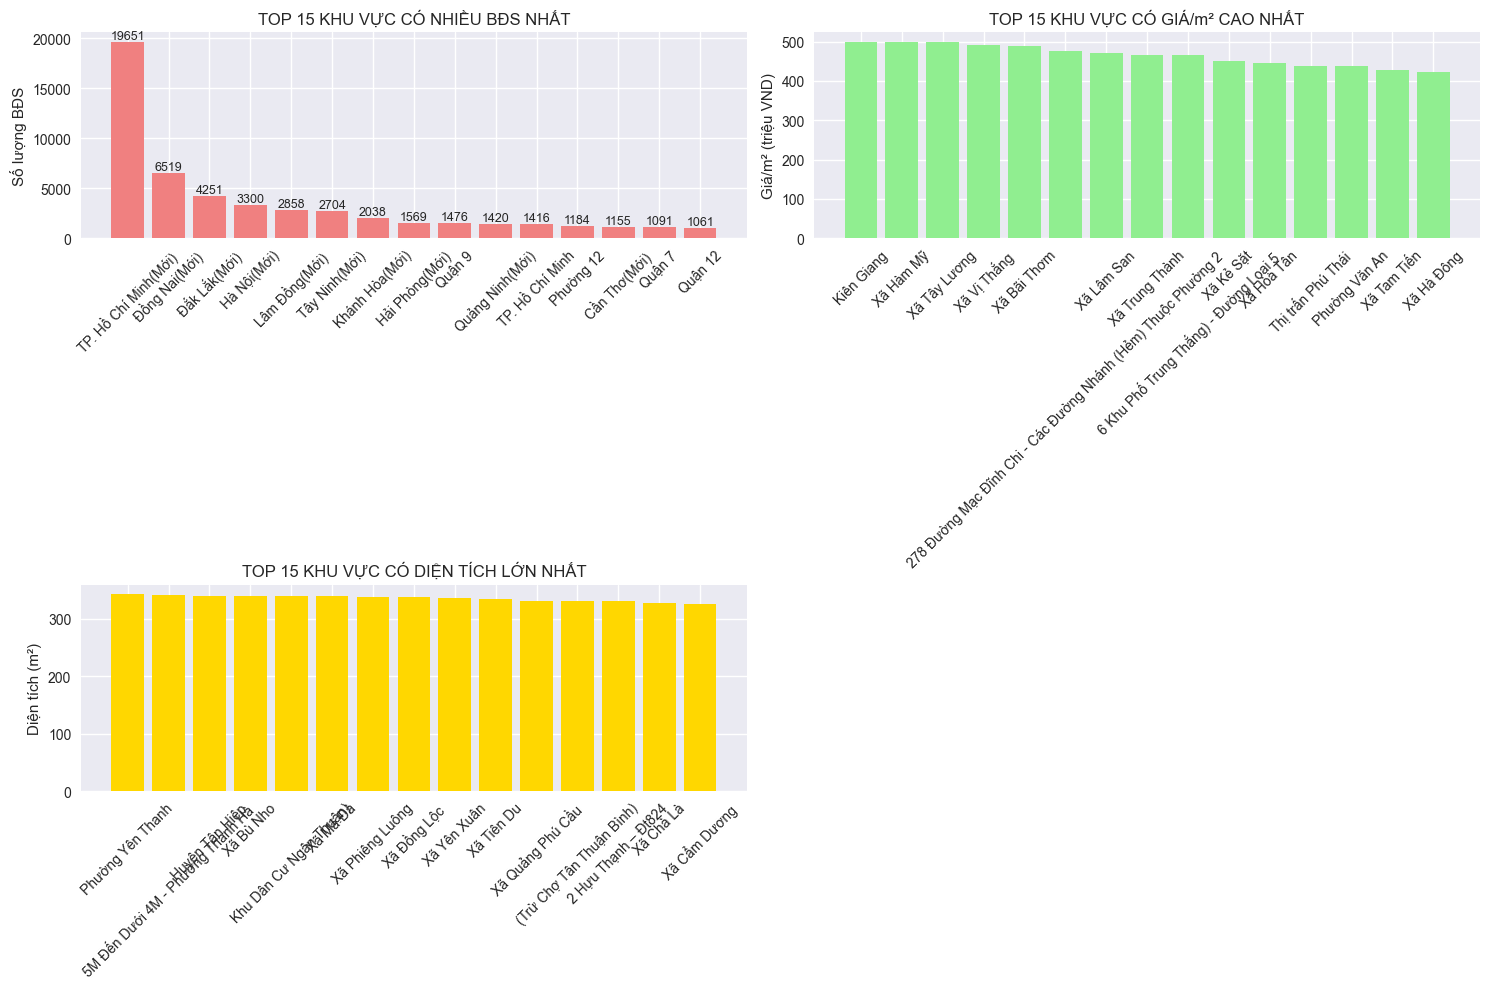

In [16]:
##  PHÂN TÍCH THEO VỊ TRÍ ĐỊA LÝ

# %%
if len(df) > 0 and 'District' in df.columns:
    # 3.1 Phân tích theo KHU VỰC
    plt.figure(figsize=(15, 10))
    
    # Top quận có nhiều BĐS nhất
    district_counts = df['District'].value_counts().head(15)
    
    plt.subplot(2, 2, 1)
    bars1 = plt.bar(range(len(district_counts)), district_counts.values, color='lightcoral')
    plt.title('TOP 15 KHU VỰC CÓ NHIỀU BĐS NHẤT')
    plt.xticks(range(len(district_counts)), district_counts.index, rotation=45)
    plt.ylabel('Số lượng BĐS')
    
    # Thêm số liệu trên cột
    for bar, count in zip(bars1, district_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{count}', 
                ha='center', va='bottom', fontsize=9)
    
    # Giá trung bình theo quận
    plt.subplot(2, 2, 2)
    district_price = df.groupby('District')['Price_per_m2'].mean().sort_values(ascending=False).head(15)
    bars2 = plt.bar(range(len(district_price)), district_price.values / 1e6, color='lightgreen')
    plt.title('TOP 15 KHU VỰC CÓ GIÁ/m² CAO NHẤT')
    plt.xticks(range(len(district_price)), district_price.index, rotation=45)
    plt.ylabel('Giá/m² (triệu VND)')
    
    # Diện tích trung bình theo quận
    plt.subplot(2, 2, 3)
    district_area = df.groupby('District')['Area_clean'].mean().sort_values(ascending=False).head(15)
    bars3 = plt.bar(range(len(district_area)), district_area.values, color='gold')
    plt.title('TOP 15 KHU VỰC CÓ DIỆN TÍCH LỚN NHẤT')
    plt.xticks(range(len(district_area)), district_area.index, rotation=45)
    plt.ylabel('Diện tích (m²)')
    
    
    plt.tight_layout()
    plt.show()

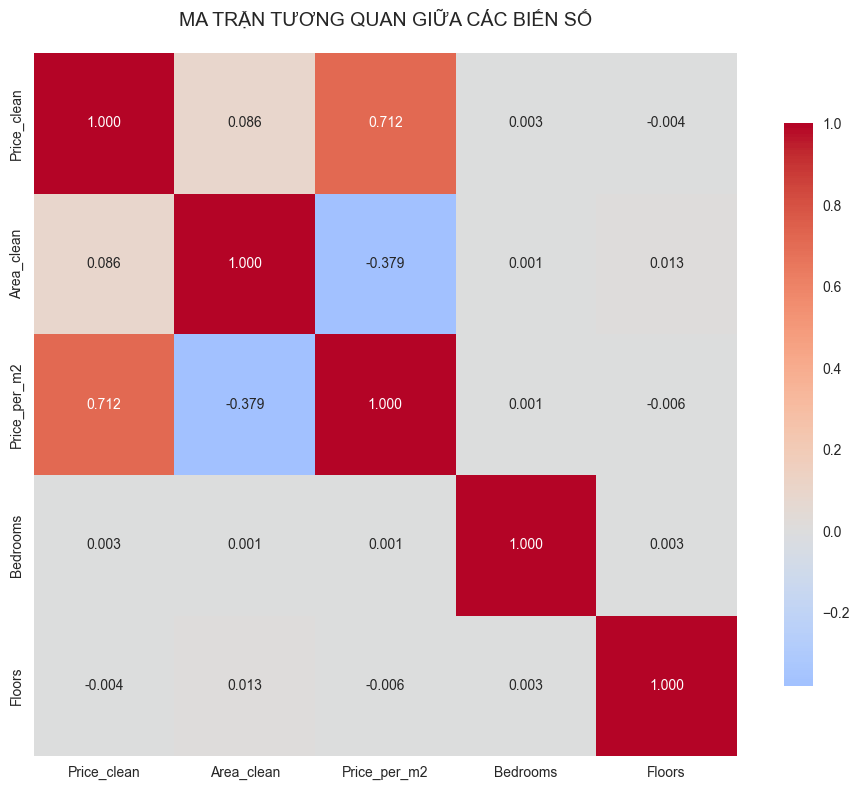

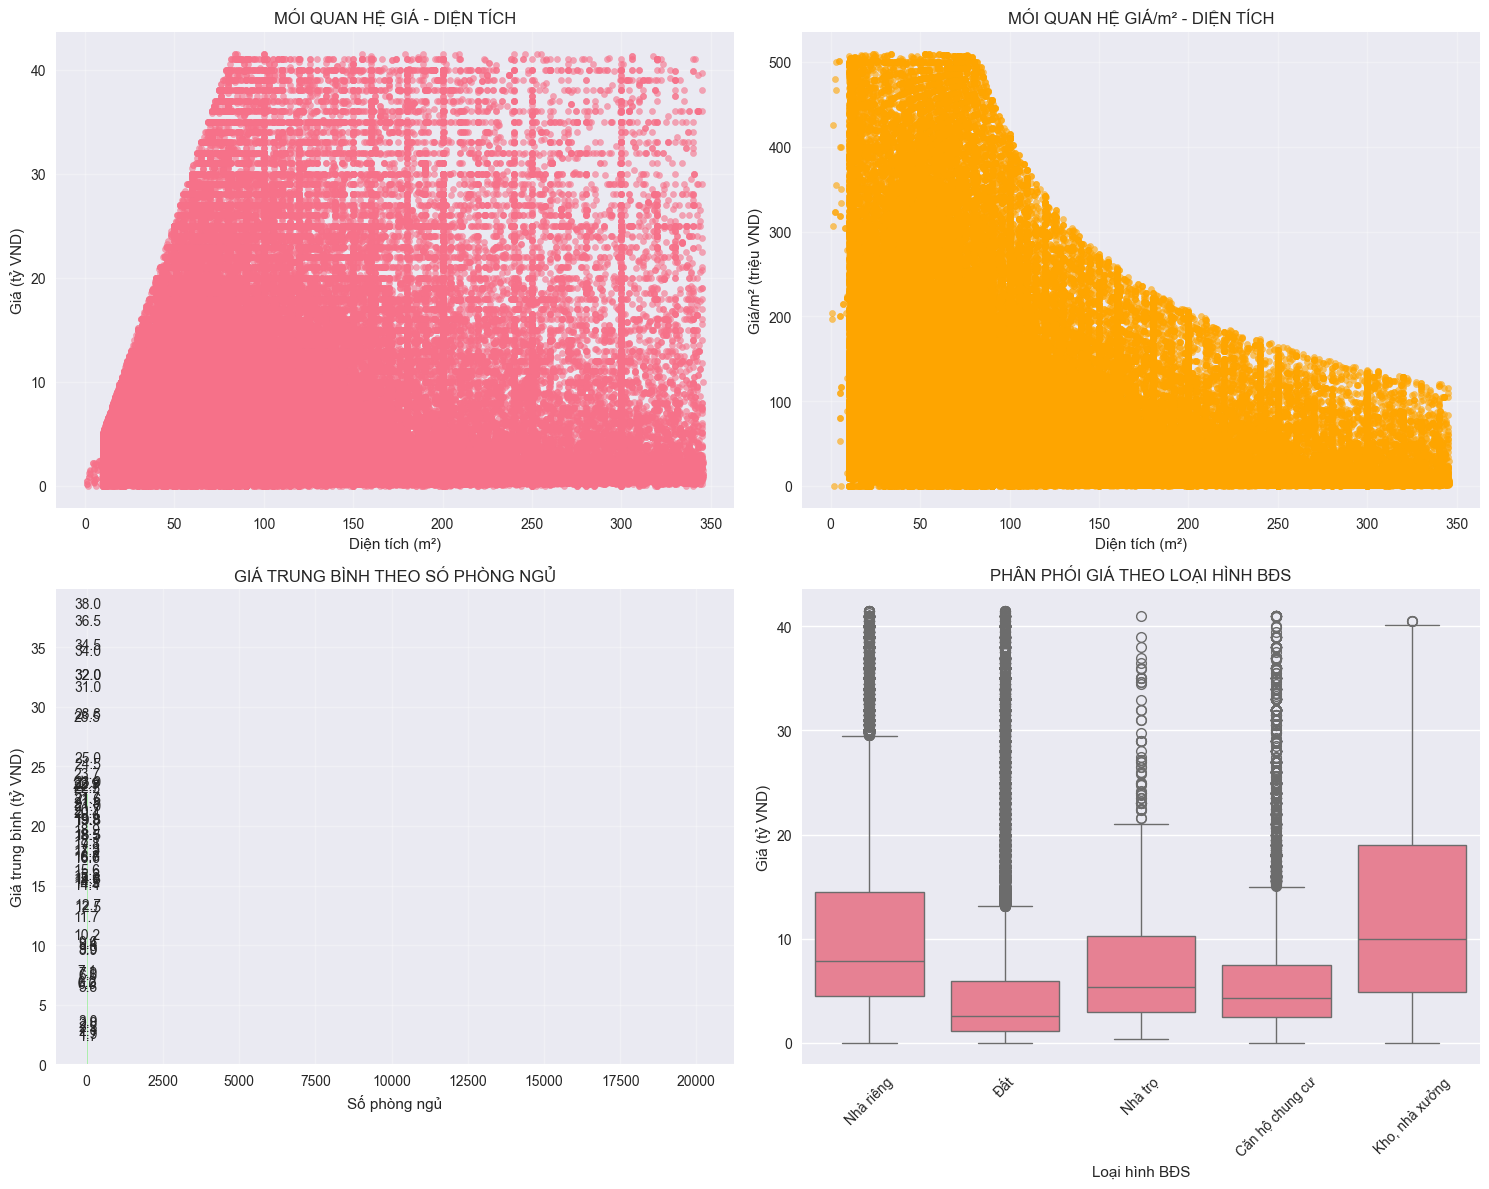

In [17]:
##  PHÂN TÍCH MỐI QUAN HỆ GIỮA CÁC BIẾN

# %%
if len(df) > 0:
    # 4.1 Ma trận tương quan
    numeric_cols = ['Price_clean', 'Area_clean', 'Price_per_m2']
    if 'Bedrooms' in df.columns:
        numeric_cols.append('Bedrooms')
    if 'Floors' in df.columns:
        numeric_cols.append('Floors')

    # Chỉ lấy các cột tồn tại
    numeric_cols = [col for col in numeric_cols if col in df.columns]
    
    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = df[numeric_cols].corr()

        # Heatmap tương quan
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                    square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
        plt.title('MA TRẬN TƯƠNG QUAN GIỮA CÁC BIẾN SỐ', fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()

        # 4.2 Phân tích chi tiết từng mối quan hệ
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Giá vs Diện tích
        axes[0,0].scatter(df['Area_clean'], df['Price_clean']/1e9, alpha=0.6, s=20)
        axes[0,0].set_xlabel('Diện tích (m²)')
        axes[0,0].set_ylabel('Giá (tỷ VND)')
        axes[0,0].set_title('MỐI QUAN HỆ GIÁ - DIỆN TÍCH')
        axes[0,0].grid(True, alpha=0.3)

        # Giá/m² vs Diện tích
        axes[0,1].scatter(df['Area_clean'], df['Price_per_m2']/1e6, alpha=0.6, s=20, color='orange')
        axes[0,1].set_xlabel('Diện tích (m²)')
        axes[0,1].set_ylabel('Giá/m² (triệu VND)')
        axes[0,1].set_title('MỐI QUAN HỆ GIÁ/m² - DIỆN TÍCH')
        axes[0,1].grid(True, alpha=0.3)

        # Giá vs Số phòng ngủ (nếu có)
        if 'Bedrooms' in df.columns:
            bedroom_price = df.groupby('Bedrooms')['Price_clean'].mean() / 1e9
            axes[1,0].bar(bedroom_price.index, bedroom_price.values, color='lightgreen', alpha=0.7)
            axes[1,0].set_xlabel('Số phòng ngủ')
            axes[1,0].set_ylabel('Giá trung bình (tỷ VND)')
            axes[1,0].set_title('GIÁ TRUNG BÌNH THEO SỐ PHÒNG NGỦ')
            axes[1,0].grid(True, alpha=0.3)
            
            # Thêm số liệu trên cột
            for i, v in enumerate(bedroom_price.values):
                axes[1,0].text(i + 1, v + 0.1, f'{v:.1f}', ha='center', va='bottom')

        # Phân phối giá theo loại hình BĐS (nếu có) - SỬA LỖI Ở ĐÂY
        if 'Property Type' in df.columns:
            # Tạo bản copy và chuyển đổi đơn vị trước
            plot_data = df.copy()
            plot_data['Price_billion'] = plot_data['Price_clean'] / 1e9
            
            top_properties = df['Property Type'].value_counts().head(5).index
            prop_data = plot_data[plot_data['Property Type'].isin(top_properties)]
            
            # Sử dụng đúng tên cột đã chuyển đổi
            sns.boxplot(data=prop_data, x='Property Type', y='Price_billion', ax=axes[1,1])
            axes[1,1].set_xlabel('Loại hình BĐS')
            axes[1,1].set_ylabel('Giá (tỷ VND)')
            axes[1,1].set_title('PHÂN PHỐI GIÁ THEO LOẠI HÌNH BĐS')
            axes[1,1].tick_params(axis='x', rotation=45)

        # Ẩn subplot không sử dụng
        for i in range(2):
            for j in range(2):
                if not axes[i,j].has_data():
                    axes[i,j].set_visible(False)

        plt.tight_layout()
        plt.show()

In [18]:
##  PHÂN TÍCH THEO THỜI GIAN (NẾU CÓ)

# %%
if len(df) > 0:
    # 5.1 Kiểm tra nếu có cột ngày tháng
    date_columns = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]

    if date_columns:
        print(f" Phát hiện cột thời gian: {date_columns}")
    else:
        print(" Không tìm thấy cột thời gian trong dataset")


 Phát hiện cột thời gian: ['Last Updated', 'Last Updated Date']


 PHÂN TÍCH TỪ KHÓA TRONG TIÊU ĐỀ
chính_chủ      : 11696 BĐS (6.8%)
giá_rẻ         : 2884 BĐS (1.7%)
view_đẹp       :  899 BĐS (0.5%)
mặt_tiền       : 25054 BĐS (14.5%)
sổ_đỏ          : 1745 BĐS (1.0%)
sổ_hồng        : 3492 BĐS (2.0%)


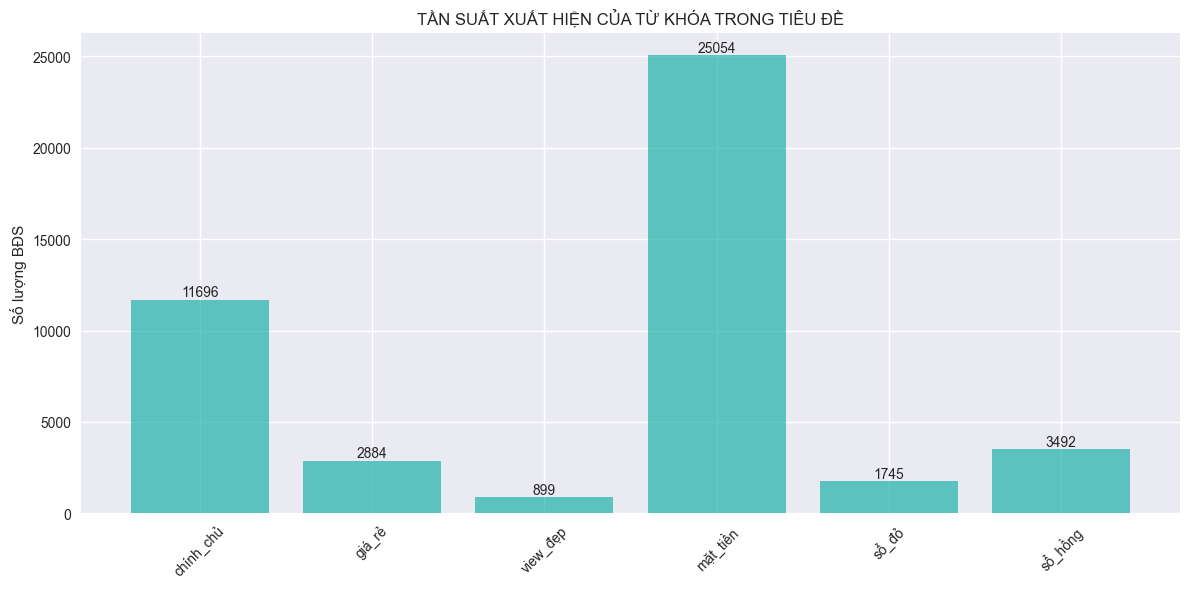

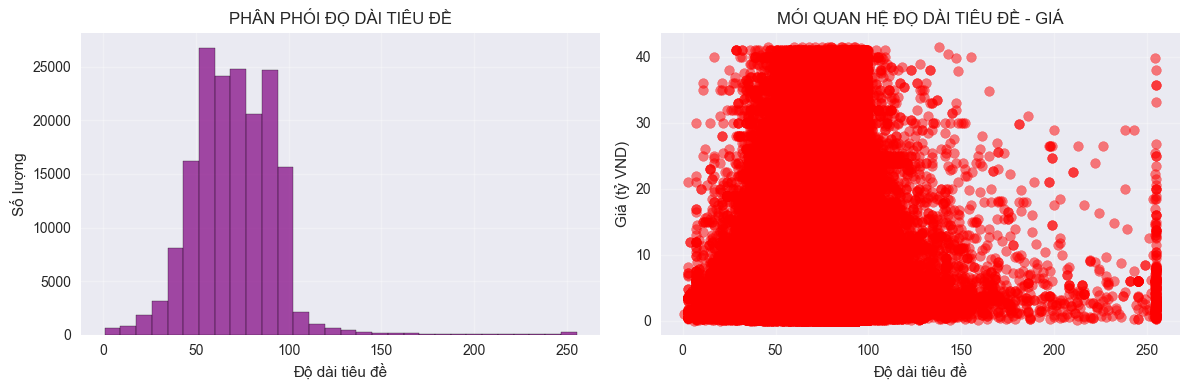

In [19]:
##  PHÂN TÍCH CÁC BIẾN PHỤ TRỢ

# %%
if len(df) > 0:
    # 6.1 Phân tích từ khóa trong tiêu đề
    keyword_cols = [col for col in df.columns if 'Keyword' in col]

    if keyword_cols:
        print(" PHÂN TÍCH TỪ KHÓA TRONG TIÊU ĐỀ")
        
        plt.figure(figsize=(12, 6))
        keyword_stats = {}
        
        for keyword_col in keyword_cols:
            count = df[keyword_col].sum()
            percentage = (count / len(df)) * 100
            keyword_name = keyword_col.replace('Keyword_', '')
            keyword_stats[keyword_name] = count
            print(f"{keyword_name:<15}: {count:>4} BĐS ({percentage:.1f}%)")
        
        # Biểu đồ từ khóa
        plt.bar(keyword_stats.keys(), keyword_stats.values(), color='lightseagreen', alpha=0.7)
        plt.title('TẦN SUẤT XUẤT HIỆN CỦA TỪ KHÓA TRONG TIÊU ĐỀ')
        plt.xticks(rotation=45)
        plt.ylabel('Số lượng BĐS')
        
        # Thêm số liệu trên cột
        for i, v in enumerate(keyword_stats.values()):
            plt.text(i, v + 5, f'{v}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

    # 6.2 Phân tích độ dài tiêu đề
    if 'Title_Length' in df.columns:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(df['Title_Length'], bins=30, alpha=0.7, edgecolor='black', color='purple')
        plt.xlabel('Độ dài tiêu đề')
        plt.ylabel('Số lượng')
        plt.title('PHÂN PHỐI ĐỘ DÀI TIÊU ĐỀ')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.scatter(df['Title_Length'], df['Price_clean']/1e9, alpha=0.5, color='red')
        plt.xlabel('Độ dài tiêu đề')
        plt.ylabel('Giá (tỷ VND)')
        plt.title('MỐI QUAN HỆ ĐỘ DÀI TIÊU ĐỀ - GIÁ')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

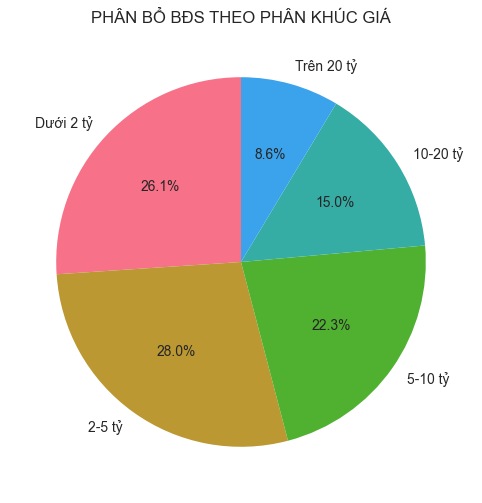

 PHÂN KHÚC GIÁ THỊ TRƯỜNG:
Dưới 2 tỷ   : 45002 BĐS (26.1%)
2-5 tỷ      : 48411 BĐS (28.0%)
5-10 tỷ     : 38568 BĐS (22.3%)
10-20 tỷ    : 25844 BĐS (15.0%)
Trên 20 tỷ  : 14865 BĐS (8.6%)

 PHÂN KHÚC DIỆN TÍCH:
Dưới 50m²   : 28065 BĐS (16.3%)
50-80m²     : 41960 BĐS (24.3%)
80-120m²    : 48024 BĐS (27.8%)
120-200m²   : 32726 BĐS (19.0%)
Trên 200m²  : 21915 BĐS (12.7%)


In [20]:
##  PHÂN TÍCH NGOẠI LỆ VÀ CỤM GIÁ TRỊ

# %%
if len(df) > 0:
    # 7.1 Phân tích các segment giá
    def create_price_segments(price_series):
        segments = {
            'Dưới 2 tỷ': (0, 2e9),
            '2-5 tỷ': (2e9, 5e9),
            '5-10 tỷ': (5e9, 10e9),
            '10-20 tỷ': (10e9, 20e9),
            'Trên 20 tỷ': (20e9, float('inf'))
        }
        
        segment_counts = {}
        for segment, (low, high) in segments.items():
            count = ((price_series >= low) & (price_series < high)).sum()
            segment_counts[segment] = count
        
        return segment_counts

    price_segments = create_price_segments(df['Price_clean'])

    plt.figure(figsize=(10, 6))
    plt.pie(price_segments.values(), labels=price_segments.keys(), autopct='%1.1f%%', startangle=90)
    plt.title('PHÂN BỔ BĐS THEO PHÂN KHÚC GIÁ')
    plt.show()

    print(" PHÂN KHÚC GIÁ THỊ TRƯỜNG:")
    for segment, count in price_segments.items():
        percentage = (count / len(df)) * 100
        print(f"{segment:<12}: {count:>4} BĐS ({percentage:.1f}%)")

    # 7.2 Phân tích các segment diện tích
    def create_area_segments(area_series):
        segments = {
            'Dưới 50m²': (0, 50),
            '50-80m²': (50, 80),
            '80-120m²': (80, 120),
            '120-200m²': (120, 200),
            'Trên 200m²': (200, float('inf'))
        }
        
        segment_counts = {}
        for segment, (low, high) in segments.items():
            count = ((area_series >= low) & (area_series < high)).sum()
            segment_counts[segment] = count
        
        return segment_counts

    area_segments = create_area_segments(df['Area_clean'])

    print("\n PHÂN KHÚC DIỆN TÍCH:")
    for segment, count in area_segments.items():
        percentage = (count / len(df)) * 100
        print(f"{segment:<12}: {count:>4} BĐS ({percentage:.1f}%)")

In [21]:
##  KẾT LUẬN EDA TỔNG QUAN

# %%
if len(df) > 0:
    print(" KẾT LUẬN EDA TỔNG QUAN")
    print("=" * 50)

    # Thống kê tổng quan
    print(f"• Tổng số BĐS phân tích: {len(df):,}")
    print(f"• Giá trung bình: {df['Price_clean'].mean()/1e9:.1f} tỷ VND")
    print(f"• Diện tích trung bình: {df['Area_clean'].mean():.0f} m²")
    print(f"• Giá/m² trung bình: {df['Price_per_m2'].mean()/1e6:.1f} triệu VND/m²")

    # Phân tích độ biến động
    price_cv = (df['Price_clean'].std() / df['Price_clean'].mean()) * 100
    area_cv = (df['Area_clean'].std() / df['Area_clean'].mean()) * 100

    print(f"• Độ biến động giá: {price_cv:.1f}%")
    print(f"• Độ biến động diện tích: {area_cv:.1f}%")

    # Phân tích tương quan
    if 'Area_clean' in df.columns and 'Price_clean' in df.columns:
        correlation = df['Area_clean'].corr(df['Price_clean'])
        print(f"• Tương quan Diện tích-Giá: {correlation:.3f}")

    # Lưu kết quả EDA
    eda_summary = {
        'total_properties': len(df),
        'avg_price': df['Price_clean'].mean(),
        'avg_area': df['Area_clean'].mean(),
        'avg_price_per_m2': df['Price_per_m2'].mean(),
        'price_std': df['Price_clean'].std(),
        'area_std': df['Area_clean'].std()
    }

    print(" HOÀN TẤT PHÂN TÍCH EDA!")
else:
    print(" KHÔNG THỂ THỰC HIỆN EDA DO THIẾU DỮ LIỆU")

 KẾT LUẬN EDA TỔNG QUAN
• Tổng số BĐS phân tích: 172,690
• Giá trung bình: 7.3 tỷ VND
• Diện tích trung bình: 108 m²
• Giá/m² trung bình: 91.9 triệu VND/m²
• Độ biến động giá: 109.2%
• Độ biến động diện tích: 64.7%
• Tương quan Diện tích-Giá: 0.086
 HOÀN TẤT PHÂN TÍCH EDA!
